# Custom dataset
The dataset we use cannot be directly. It varies depending upon the type of data (text, img, tabular etc.). Therefore, we need to `preprocess` the dataset so that it can be used with pytorch.

In this notebook, we will use a subset of the famous `Food101` which has 101 different classes of food and 1000 images per class (750 training and 250 testing). Our subset consists of **3 classes** and only **10% of the total images**. This is done becuase, for all ML projects its important to try things on a small scale and then increase the scale when necessary to `speed up experimentation`.

In [1]:
import torch
from torch import nn

import matplotlib.pyplot as plt

In [2]:
# set device agnostic code
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# 1. Get data

In [3]:
import requests
import zipfile
from pathlib import Path

In [4]:
# create path
data_path = Path("../Dataset/")
img_path = data_path / "pizza_steak_sushi" # data image path

img_path.mkdir(parents=True, exist_ok=True) # create path if not exist

In [15]:
# download data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:

    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    print("Download data ...")
    
    f.write(request.content) # writing data to the zip file

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as f:
    print("unzipping file ...")
    f.extractall(img_path)

Download data ...
unzipping file ...


# 2. Data exploration and preparation

### a. Explore data paths

In [18]:
import os

# walks through dir_path returning its content
def walk_through_dir(dir_path):

    for dirpath, dirnames, filenames in os.walk(dir_path): # goes inside each path of dirpath

        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(img_path) # we can see ~10% each class (75+25)

There are 2 directories and 0 images in ..\Dataset\pizza_steak_sushi
There are 3 directories and 0 images in ..\Dataset\pizza_steak_sushi\test
There are 1 directories and 25 images in ..\Dataset\pizza_steak_sushi\test\pizza
There are 0 directories and 2 images in ..\Dataset\pizza_steak_sushi\test\pizza\.ipynb_checkpoints
There are 0 directories and 19 images in ..\Dataset\pizza_steak_sushi\test\steak
There are 0 directories and 31 images in ..\Dataset\pizza_steak_sushi\test\sushi
There are 3 directories and 0 images in ..\Dataset\pizza_steak_sushi\train
There are 0 directories and 78 images in ..\Dataset\pizza_steak_sushi\train\pizza
There are 0 directories and 75 images in ..\Dataset\pizza_steak_sushi\train\steak
There are 0 directories and 72 images in ..\Dataset\pizza_steak_sushi\train\sushi


In [12]:
train_dir = img_path / "train"
test_dir = img_path / "test"

This is the standard format for storing image data. That is `train and test data separately` and `each class in separate folder`

### b. Explore data by visualising

Image class steak.
Image height 512.
Image width 512.


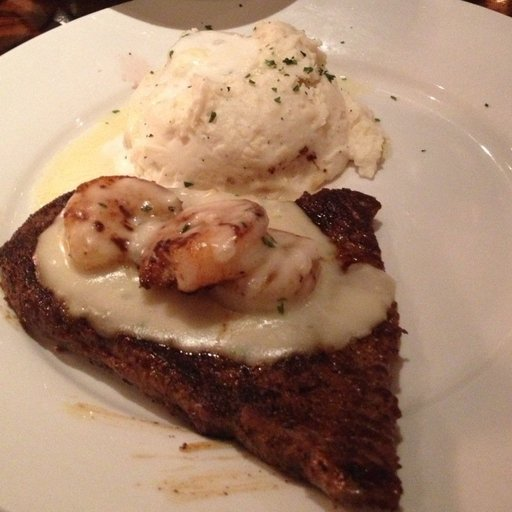

In [5]:
# lets visualise an image
import random
from PIL import Image

# get all image paths
img_path_list = list(img_path.glob("*/*/*.jpg"))

# pick a random img path
rdn_img_path = random.choice(img_path_list)

# get the img from path
img = Image.open(rdn_img_path)

# class of the img
img_class = rdn_img_path.parent.stem

# img metadata
print(f"Image class {img_class}.")
print(f"Image height {img.height}.")
print(f"Image width {img.width}.")

img

Image class sushi | Image shape: (384, 512, 3) HWC format


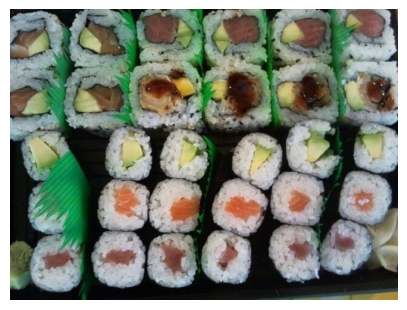

In [59]:
# with matplotlib
import numpy as np

img_arr = np.array(img) # since matplotlib doesn't work with PIL

print(f"Image class {img_class} | Image shape: {img_arr.shape} HWC format")
plt.figure(figsize=(5,5))
plt.imshow(img_arr)
plt.axis(False)
plt.show()

### c. Convert image to tensor (datasets) and manipulate if required
We can see all the images are varying in height and width. PyTorch expects image of same size, therefore we need to do `random resizing` or `cropping` of partial size.
1. Turn data into `torch.utils.data.Dataset`
2. Turn further into `torch.utils.data.DataLoader`

**Data augmentation** to get state of the art results, read https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [6]:
from torchvision import datasets, transforms

In [7]:
# transform data - write all required transformations in a list
data_transform = transforms.Compose([transforms.Resize(size=(64,64)),
                                     # transforms.RandomHorizontalFlip(p=0.5), # 50% of time image will be horizontally flipped
                                     transforms.ToTensor()]) # convert PIL (or) np array to tensor

In [102]:
# compare actual and tranformed image
def comp_img_transfImg(img_paths: list, transform, 
                       n = 3, seed = None):
    if seed:
        random.seed(42)

    # random paths of 3 images
    rdn_img_paths = random.sample(img_path_list, k=n) 

    for img_path in rdn_img_paths:
        with Image.open(img_path) as f:
            fig,ax = plt.subplots(nrows=1, ncols=2)

            ax[0].imshow(f)
            ax[0].set_title(f"Original shape: {f.size}")
            ax[0].axis(False)

            transf_img = transform(f)
            ax[1].imshow(transf_img.permute(1,2,0))
            ax[1].set_title(f"Transformed shape: {transf_img.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {img_path.parent.stem}")
            fig.tight_layout()

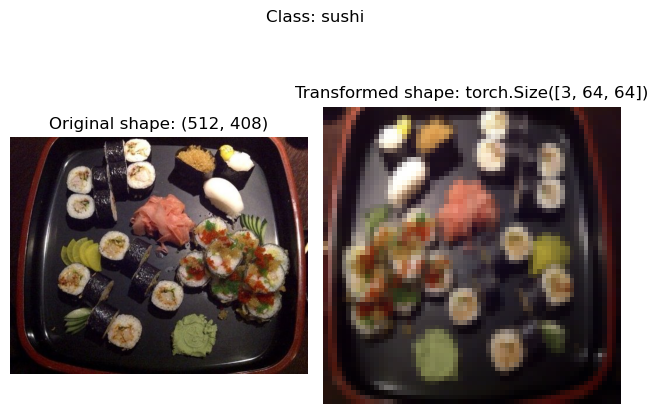

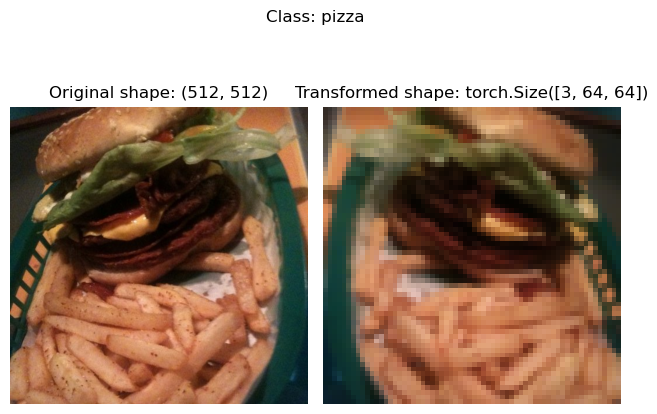

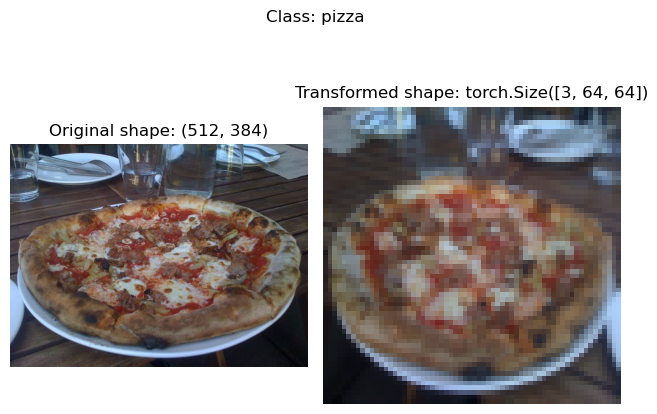

In [103]:
comp_img_transfImg(img_paths=img_path_list, transform=data_transform,
                   n=3, seed=4)

For all images to replicate ImageFolder to convert to datasets format

To replicate, we can see from below that
1. Subclass `torch.utils.data.dataset` as it is a base class for all the dataset functions.
2. Create several attributes
   * paths - img paths
   * transform - the transformation that is performed
   * classes - Get classes in a list
   * class_to_idx - dict of the target class with index
4. Create a function to `load_images()` which opens an image
5. Overwrite `__len__()` to return the length of our dataset - this is optional
6. Overwrite `__getitem__()` method to return a data when an index is passed - this is mandatory and must overwrite dataset class
   * Get data when indexed as [[data],[label]] list format

**Pros**
* Can create a `Dataset` out of anything.
* Required in cases where the prebuilt `Dataset` functions doesn't exist for our custom dataset.

We need to subclass `torch.utils.data.dataset` as it is a base class for all the dataset functions.

https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [20]:
from torch.utils.data import Dataset
import os

### 1. subclass dataset ###
class CustomImageFolder(Dataset):

    def __init__(self, target_dir : str, transform=None): # target_dir - train or test directory

        ### 2. create class attributes ###
        # all image paths
        self.path = list(Path(target_dir).glob("*/*.jpg")) 

        # setup transform
        self.transform = transform

        # create classes and class_to_idx
        self.classes, self.class_to_idx = self.find_class(target_dir)

    ### 3. create a img function to open an image ###
    def load_image(self, index : int):
        img_path = self.path[index]

        return Image.open(img_path) # show the PIL image

    ### 4. Overwrite __len__() to return total number of data ###
    def __len__(self):
        return len(self.path)

    ### 5. overwrite __getitem__() to return one sample of data ###
    def __getitem__(self, index: int): # replicates eg:train_data[0]

        # open image using PIL
        img = self.load_image(index)

        # class index
        class_name = self.path[index].parent.name
        class_idx = self.class_to_idx[class_name]

        # transform and convert to tensor if given
        if self.transform:
            img = self.transform(img)

        return img, class_idx # return in required format

    ### 1. get class names and their indices ### 
    def find_class(self, target_dir):
    
        # get class names from target directory
        class_names = sorted([entry.name for entry in list(os.scandir(target_dir))])
    
        # raise an error if no directory is present
        if not class_names:
            raise FileNotFoundError(f"Not able to find any classes in {direc}")
    
        # get class names with index
        class_to_idx = {name:i for i, name in enumerate(class_names)}
    
        return class_names, class_to_idx

In [21]:
cust_train_data = CustomImageFolder(target_dir=train_dir, transform=data_transform)

cust_test_data = CustomImageFolder(target_dir=test_dir, transform=data_transform)

### c1. Done using ImageFolder
Can be done if the data is stored in standard image format

In [13]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # transform of data
                                  target_transform=None) # transform for label

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform, # transformation not typically done on test data
                                  target_transform=None) # transform for label

In [22]:
# check for equality of custom and fn
"equal" if (torch.eq(cust_train_data[0][0], train_data[0][0]).sum()/(3*64*64) == 1.) else "not equal"

'equal'

### d. Turn datasets into dataloader
DataLoader converts datasets to iterables of minibatches

In [23]:
from torch.utils.data import DataLoader

In [24]:
batch_size = 16

# training minibatches
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size,
                              num_workers=2, shuffle=True)

# testing minibatches
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size,
                              num_workers=2, shuffle=False)

# 3. Build Model without data augmentation

Replicate the TinyVGG architecture from CNN explainer website

In [25]:
def H_W_out(image_shape, pad, kernel, stride, dilation=1):
    '''Output data shape after convolution'''

    H_out = int((image_shape + 2*pad - dilation * (kernel -1) -1)/stride +1) # output height of data
    W_out = int((image_shape + 2*pad - dilation * (kernel -1) -1)/stride +1) # output width of data
    return H_out, W_out

In [26]:
class TinyVGG(nn.Module):
    def __init__(self, inp_features: int,
                 hidden_units : int,
                 out_shape : int,
                image_shape : int):

        super().__init__()

        PADDING, STRIDE, KERNEL = 1, 2, 3
        
        self.conv_block_1 = nn.Sequential(nn.Conv2d(in_channels=inp_features,
                                                    out_channels=hidden_units,
                                                   kernel_size=3, stride=1,
                                                   padding=1),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=hidden_units,
                                                    out_channels=hidden_units,
                                                    kernel_size=KERNEL, stride=STRIDE,
                                                    padding=PADDING),
                                          nn.ReLU())
        
        DILATION = 1 # default
        
        H_out, W_out = H_W_out(image_shape, PADDING, KERNEL, STRIDE, DILATION) # used for computing the input shape for classifier layer

        PADDING, STRIDE, KERNEL = 1, 2, 3

        self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels=hidden_units,
                                                    out_channels=hidden_units,
                                                    kernel_size=3, stride=1,
                                                    padding=1),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=hidden_units,
                                                    out_channels=hidden_units,
                                                    kernel_size=KERNEL, stride=STRIDE,
                                                    padding=PADDING),
                                          nn.ReLU())
        
        H_out, W_out = H_W_out(H_out, PADDING, KERNEL, STRIDE, DILATION)
        
        # output classifier layer
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features=hidden_units*H_out*W_out, # trick is to run without the hard coded value and find the shape by seeing at the error
                                                  out_features=out_shape))

    
    def forward(self,x):
        x = self.conv_block_1(x)
        # print(f"Shape of first block {x.shape}")
        
        x = self.conv_block_2(x)
        # print(f"Shape of first block {x.shape}")

        x = self.classifier(x)   # doing it combinedly without doing it deparately will fasten. This is the benefit from operator fusion. Doing separately - goes from computation to memory and then again
        return x                 # https://horace.io/brrr_intro.html

In [34]:
# instantiate our model
torch.manual_seed(42)

model_0 = TinyVGG(inp_features=3,
                  hidden_units= 32,
                  out_shape= 3, image_shape=64).to(device)

# 4. Training

In [35]:
loss_fn = nn.CrossEntropyLoss()

optim = torch.optim.SGD(params=model_0.parameters(),
                        lr = 0.1) # optimiser

In [36]:
# functionising training and testing loops

def train_step(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn : torch.nn.Module,
             optimizer : torch.optim.Optimizer,
             accuracy_fn,
             device : torch.device = device):

    train_loss, train_acc = 0, 0

    # put model into training mode
    model.train()

    for X, y in data_loader:

        X, y = X.to(device), y.to(device) # data on target device
        
        # 1. forward pass
        y_pred = model(X)

        # 2. calculate loss and accuracy per batch
        loss = loss_fn(y_pred, y)
        train_loss += loss
        
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3.optimiser zero grad
        optim.zero_grad()

        # 4.loss backward
        loss.backward()

        # 5. step
        optim.step()

    train_loss /= len(data_loader) # div by number of batches to get the average loss per epoch
    train_acc /= len(data_loader)

    print(f"Model: {model.__class__.__name__} | train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}%")

def test_step(model : torch.nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              optimizer : torch.optim.Optimizer,
              accuracy_fn,
              device : torch.device = device):
              
    test_loss, test_acc = 0, 0

    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device) # data on target device

            # 1. forward pass
            test_pred = model(X)

            # calculate loss per batch
            test_loss += loss_fn(test_pred, y)

            # accuracy
            test_acc += accuracy(y_true=y, y_pred=test_pred.argmax(dim=1)) # to get the labels and get the accuracy
    
        # avg test loss per epoch
        test_loss /= len(data_loader)
    
        # average accuracy per epoch
        test_acc /= len(data_loader)

    print(f"Model: {model.__class__.__name__} | Test loss: {test_loss:.4f}, test accuracy: {test_acc}% \n")

In [31]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # computes element wise equality
    return (correct/len(y_pred))*100

In [37]:
torch.manual_seed(42)

epochs = 20

for epoch in range(epochs):

    print(f"Epoch: {epoch + 1}\n")

    # training
    train_step(model=model_0, data_loader=train_dataloader,
               loss_fn=loss_fn, optimizer=optim,
               accuracy_fn=accuracy, device=device)

    # testing
    test_step(model=model_0, data_loader=test_dataloader,
               loss_fn=loss_fn, optimizer=optim,
               accuracy_fn=accuracy, device=device)

Epoch: 1

Model: TinyVGG | train loss: 1.1003 | Train acc: 36.6667%
Model: TinyVGG | Test loss: 1.1134, test accuracy: 33.75% 

Epoch: 2

Model: TinyVGG | train loss: 1.0959 | Train acc: 38.7500%
Model: TinyVGG | Test loss: 1.1208, test accuracy: 33.75% 

Epoch: 3

Model: TinyVGG | train loss: 1.0946 | Train acc: 35.4167%
Model: TinyVGG | Test loss: 1.1009, test accuracy: 33.75% 

Epoch: 4

Model: TinyVGG | train loss: 1.1014 | Train acc: 33.7500%
Model: TinyVGG | Test loss: 1.1120, test accuracy: 23.75% 

Epoch: 5

Model: TinyVGG | train loss: 1.0807 | Train acc: 46.2500%
Model: TinyVGG | Test loss: 1.0647, test accuracy: 41.25% 

Epoch: 6

Model: TinyVGG | train loss: 0.9675 | Train acc: 51.6667%
Model: TinyVGG | Test loss: 23.6008, test accuracy: 23.75% 

Epoch: 7

Model: TinyVGG | train loss: 2.3005 | Train acc: 32.9167%
Model: TinyVGG | Test loss: 1.1171, test accuracy: 33.75% 

Epoch: 8

Model: TinyVGG | train loss: 1.0959 | Train acc: 37.5000%
Model: TinyVGG | Test loss: 1.1121,

### a. Get information on the training

In [39]:
from torchinfo import summary

In [40]:
summary(model_0, input_size=[16,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [16, 3]                   --
├─Sequential: 1-1                        [16, 32, 32, 32]          --
│    └─Conv2d: 2-1                       [16, 32, 64, 64]          896
│    └─ReLU: 2-2                         [16, 32, 64, 64]          --
│    └─Conv2d: 2-3                       [16, 32, 32, 32]          9,248
│    └─ReLU: 2-4                         [16, 32, 32, 32]          --
├─Sequential: 1-2                        [16, 32, 16, 16]          --
│    └─Conv2d: 2-5                       [16, 32, 32, 32]          9,248
│    └─ReLU: 2-6                         [16, 32, 32, 32]          --
│    └─Conv2d: 2-7                       [16, 32, 16, 16]          9,248
│    └─ReLU: 2-8                         [16, 32, 16, 16]          --
├─Sequential: 1-3                        [16, 3]                   --
│    └─Flatten: 2-9                      [16, 8192]                --
│    

# 5. Prediction on a new dataset

For our purpose, lets take a testing dataset and make prediction

The image given is a pizza with probability of 0.364


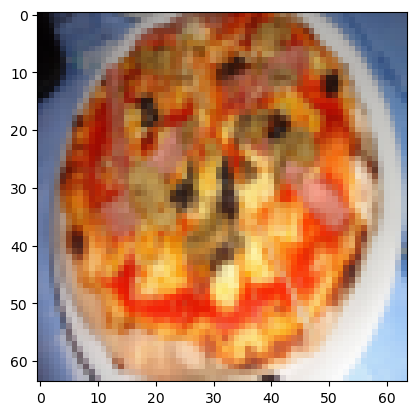

In [87]:
X_pred = img_path / "train/pizza/1089334.jpg"

import torchvision 

# converts img path to tensor of uint8 of CHW
X_pred = torchvision.io.read_image(X_pred)

# to float32
X_pred = X_pred.type(torch.float32) / 255. # scale img as training data was of the range [0,1]

# transform to 64X64
dtranf = transforms.Compose([transforms.Resize(size=(64,64))])                           
X_pred = dtranf(X_pred).to(device=device)

# since model expects batch as first dimension
X_pred = X_pred.unsqueeze(0)

model_0.eval()

with torch.inference_mode():

    y_pred = model_0(X_pred).argmax() # or perform sofmtax on this logits, will yield the same result.

    print(f"The image given is a {train_data.classes[y_pred]} with probability of {torch.softmax(model_0(X_pred), dim=1).to('cpu').max():.3f}")

    # plot the img
    X_pred_for_plt = X_pred.squeeze().permute(1,2,0)

    X_pred_for_plt = X_pred_for_plt.to("cpu").numpy() # as matplotlib cannot plot tensors

    plt.imshow(X_pred_for_plt)

We can see that though the model accuracy is low, we are able to make the prediction for this instance accurately but with a very low probability.